In [317]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [318]:
# Generating a random binary string of length 50
string_length = 50
random_string = torch.randint(0, 2, (string_length,), dtype=torch.float32, requires_grad=True)


# Parameters
num_kernel = 10  # Number of kernels
M = 5            # Maximum kernel length
eps = 1        # Epsilon for relu_distance calculation
epochs = 1      # Number of epochs for optimization
lr = 0.1        # Learning rate

# Debug: Print the generated random string
print("Generated random binary string:")
print(random_string)


Generated random binary string:
tensor([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.],
       requires_grad=True)


In [319]:
class Seqs(nn.Module):
    def __init__(self, dim, num_kernels):
        super(Seqs, self).__init__()
        self.dim = dim  # Kernel length
        self.num_kernels = num_kernels  # Number of kernels
        self.p = nn.Parameter(torch.rand(num_kernels, dim, dtype=torch.float32), requires_grad=True)

    def forward(self):
        # Debug: Check that the parameter p requires gradients
        print(f"Parameter p (before forward, requires_grad={self.p.requires_grad}):\n{self.p}")

        # Forward computation
        prob = self.p  # Kernel probabilities
        logits = torch.stack((prob, 1 - prob), dim=-1)

        # Debug: Check that logits is connected to the computation graph
        print(f"Logits grad_fn: {logits.grad_fn}")

        S = F.gumbel_softmax(logits, tau=0.5, hard=True, dim=-1)[..., 0]

        # Debug: Check that S is connected to the computation graph
        print(f"Output S (grad_fn={S.grad_fn}):\n{S}")

        return S


In [320]:
"""# Example of usage during training
seq_model = Seqs(2, 3)  # Model with dimension 2 and 3 kernels
optimizer = torch.optim.Adam(seq_model.parameters(), lr=0.01)

# Dummy input
input_string = torch.randint(0, 2, (10,)).float()  # Random binary string

# Forward pass
output = seq_model()

# Dummy loss
loss = output.sum()

# Backward pass
loss.backward()

# Debug: Gradient of p
print(f"Gradient of p after backward:\n{seq_model.p.grad}")"""

'# Example of usage during training\nseq_model = Seqs(2, 3)  # Model with dimension 2 and 3 kernels\noptimizer = torch.optim.Adam(seq_model.parameters(), lr=0.01)\n\n# Dummy input\ninput_string = torch.randint(0, 2, (10,)).float()  # Random binary string\n\n# Forward pass\noutput = seq_model()\n\n# Dummy loss\nloss = output.sum()\n\n# Backward pass\nloss.backward()\n\n# Debug: Gradient of p\nprint(f"Gradient of p after backward:\n{seq_model.p.grad}")'

In [321]:
# Generate a model for each dimension from 1 to M
seq_models = [Seqs(dim, num_kernel) for dim in range(1, M + 1)]

# Generate binary kernels directly from the model (without detach)
binary_kernels = [model() for model in seq_models]

# Debug: Display the generated binary kernels
for dim, kernels in enumerate(binary_kernels, start=1):
    print(f"Binary kernels (dim {dim}):")
    print(kernels)


Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.8202],
        [0.7107],
        [0.3711],
        [0.5225],
        [0.0151],
        [0.4425],
        [0.1490],
        [0.6711],
        [0.6322],
        [0.9878]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x17563a100>
Output S (grad_fn=<SelectBackward0 object at 0x17563a100>):
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.5792, 0.6206],
        [0.6665, 0.6176],
        [0.4997, 0.5996],
        [0.5633, 0.2001],
        [0.8886, 0.5704],
        [0.2414, 0.4643],
        [0.4607, 0.6583],
        [0.8348, 0.0829],
        [0.5344, 0.9818],
        [0.0309, 0.8664]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x17563a100>
Output S (grad_fn=<SelectBackward0 o

In [322]:
def create_patches(string, k):
    # Manually slice the string to create patches while ensuring gradient flow
    patches = [string[i:i + k].unsqueeze(0) for i in range(len(string) - k + 1)]
    return torch.cat(patches, dim=0)


In [323]:
def ZivEntropy(binary_kernels, string, eps=1):

    ziv_probs = []

    for k, kernels in enumerate(binary_kernels, start=1):
        patches = create_patches(string, k)  # Replace unfold with custom function
        print(f"Patches (k={k}): requires_grad={patches.requires_grad}, shape={patches.shape}")
        print(f"Binary kernels (dim {k}): {kernels}")


        # Manual calculation of Manhattan distances
        distances = torch.abs(patches.unsqueeze(1) - kernels.unsqueeze(0)).sum(dim=-1)
        print(f"Distances (dim {k}): {distances}")
        print(f"Distances grad_fn (dim {k}): {distances.grad_fn}")

        # Debug: Check that distances are part of the computational graph
        print(f"Manhattan distances (k={k}): requires_grad={distances.requires_grad}, grad_fn={distances.grad_fn}")

        # ReLU distance calculations
        relu_distances = F.relu(eps - distances) / eps

        # Debug: Check that relu_distances are connected to the graph
        print(f"ReLU distances (k={k}): requires_grad={relu_distances.requires_grad}, grad_fn={relu_distances.grad_fn}")

        # Probability calculations
        probs = relu_distances.sum(dim=0) / (len(patches) * num_kernel)

        # Debug: Check that probs are connected to the graph
        print(f"Probabilities (unnormalized) (k={k}): requires_grad={probs.requires_grad}, grad_fn={probs.grad_fn}")

        # Normalization of probabilities
        normalized_probs = probs / probs.sum()

        # Debug: Check that normalized_probs support gradients
        print(f"Normalized probabilities (k={k}): requires_grad={normalized_probs.requires_grad}, grad_fn={normalized_probs.grad_fn}")

        ziv_probs.append(normalized_probs)

    return ziv_probs


In [324]:
"""# Test of the ZivEntropy function with an example
dim = 3  # Kernel dimension
num_kernels = 5  # Number of kernels
string_length = 10  # Length of the binary string

# Creating a Seqs model
seq_model = Seqs(dim, num_kernels)

# Generating binary kernels
binary_kernels = [seq_model()]  # Simulating one dimension with binary kernels

# Debug: Check that the binary kernels are connected to the computation graph
for kernel_index, kernel in enumerate(binary_kernels, start=1):
    print(f"Binary kernel {kernel_index}: requires_grad={kernel.requires_grad}")

# Generating a random binary string
random_string = torch.randint(0, 2, (string_length,), dtype=torch.float32, requires_grad=True)

# Debug: Check if the binary string requires gradients
print(f"Does the binary string require gradients? {'True' if random_string.requires_grad else 'False'}")

# Epsilon
eps = 0.5

# Test of the ZivEntropy function
ziv_probs = ZivEntropy(binary_kernels, random_string, eps=eps)

# Debug: Print probabilities to verify connection to the computation graph
for k, probs in enumerate(ziv_probs, start=1):
    print(f"Normalized probabilities (dim={k}):\n{probs}")
    print(f"Probabilities grad_fn: {probs.grad_fn}")
    print(f"Do probabilities (dim={k}) require gradients? {'True' if probs.requires_grad else 'False'}")"""


'# Test of the ZivEntropy function with an example\ndim = 3  # Kernel dimension\nnum_kernels = 5  # Number of kernels\nstring_length = 10  # Length of the binary string\n\n# Creating a Seqs model\nseq_model = Seqs(dim, num_kernels)\n\n# Generating binary kernels\nbinary_kernels = [seq_model()]  # Simulating one dimension with binary kernels\n\n# Debug: Check that the binary kernels are connected to the computation graph\nfor kernel_index, kernel in enumerate(binary_kernels, start=1):\n    print(f"Binary kernel {kernel_index}: requires_grad={kernel.requires_grad}")\n\n# Generating a random binary string\nrandom_string = torch.randint(0, 2, (string_length,), dtype=torch.float32, requires_grad=True)\n\n# Debug: Check if the binary string requires gradients\nprint(f"Does the binary string require gradients? {\'True\' if random_string.requires_grad else \'False\'}")\n\n# Epsilon\neps = 0.5\n\n# Test of the ZivEntropy function\nziv_probs = ZivEntropy(binary_kernels, random_string, eps=eps)\n

In [325]:
def ZivEntropyLoss(ziv_probs):
    entropies_per_dim = []

    for probs in ziv_probs:
        probs = probs + 1e-8  # Avoid log(0)
        H_values = -(probs * probs.log())
        H_mean = H_values.mean()
        entropies_per_dim.append(H_mean)

    full_entropy = torch.stack(entropies_per_dim).sum()
    return full_entropy


In [326]:
"""# Test of the ZivEntropyLoss function

# Simulate normalized probabilities generated by ZivEntropy
ziv_probs = [
    torch.tensor([0.2, 0.3, 0.5], requires_grad=True),  # Probabilities for dim=1
    torch.tensor([0.1, 0.2, 0.4, 0.3], requires_grad=True),  # Probabilities for dim=2
    torch.tensor([0.3, 0.3, 0.2, 0.2], requires_grad=True)  # Probabilities for dim=3
]

# Debug: Check if tensors in ziv_probs require gradients
for dim_index, probs in enumerate(ziv_probs, start=1):
    print(f"Dimension {dim_index}: requires_grad={probs.requires_grad}")

# Compute the loss
full_entropy = ZivEntropyLoss(ziv_probs)

# Debug: Check connection to the computation graph for full_entropy
print(f"Does Full Entropy require gradients? {'True' if full_entropy.grad_fn is not None else 'False'}")

# Backpropagation to verify gradients
full_entropy.backward()

# Debug: Print gradients for each dimension
for dim_index, probs in enumerate(ziv_probs, start=1):
    print(f"Gradient for probabilities of dimension {dim_index}: {probs.grad}")
    print(f"Is gradient computed for dim {dim_index}? {'True' if probs.grad is not None else 'False'}")"""

'# Test of the ZivEntropyLoss function\n\n# Simulate normalized probabilities generated by ZivEntropy\nziv_probs = [\n    torch.tensor([0.2, 0.3, 0.5], requires_grad=True),  # Probabilities for dim=1\n    torch.tensor([0.1, 0.2, 0.4, 0.3], requires_grad=True),  # Probabilities for dim=2\n    torch.tensor([0.3, 0.3, 0.2, 0.2], requires_grad=True)  # Probabilities for dim=3\n]\n\n# Debug: Check if tensors in ziv_probs require gradients\nfor dim_index, probs in enumerate(ziv_probs, start=1):\n    print(f"Dimension {dim_index}: requires_grad={probs.requires_grad}")\n\n# Compute the loss\nfull_entropy = ZivEntropyLoss(ziv_probs)\n\n# Debug: Check connection to the computation graph for full_entropy\nprint(f"Does Full Entropy require gradients? {\'True\' if full_entropy.grad_fn is not None else \'False\'}")\n\n# Backpropagation to verify gradients\nfull_entropy.backward()\n\n# Debug: Print gradients for each dimension\nfor dim_index, probs in enumerate(ziv_probs, start=1):\n    print(f"Gradi

In [327]:
# Optimizer for the model parameters
#optimizer = torch.optim.Adam([param for model in seq_models for param in model.parameters()], lr=lr)
optimizer = torch.optim.Adam([
    {'params': seq_models[dim - 1].parameters(), 'lr': lr * (5 / dim)} for dim in range(1, 6)
])


losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    
    # Calculate probabilities using ZivEntropy
    ziv_probs = ZivEntropy(binary_kernels, random_string, eps=eps)

    # Calculate the loss
    full_entropy = ZivEntropyLoss(ziv_probs)

    # Save the loss to the list
    losses.append(full_entropy.item())

    # Backpropagation
    full_entropy.backward(retain_graph=True)

    for dim, model in enumerate(seq_models, start=1):
        print(f"Gradient magnitude for kernel (dim {dim}): {model.p.grad.abs().mean().item()}")

    # Debug: Display the total entropy
    print(f"Full Entropy (Epoch {epoch + 1}): {full_entropy.item()}")

    # Debug: Gradients for each dimension
    for dim, model in enumerate(seq_models, start=1):
        print(f"Kernel gradients (dim {dim}):\n{model.p.grad}")

    # Update the parameters
    optimizer.step()


Patches (k=1): requires_grad=True, shape=torch.Size([50, 1])
Binary kernels (dim 1): tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SelectBackward0>)
Distances (dim 1): tensor([[0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1.,

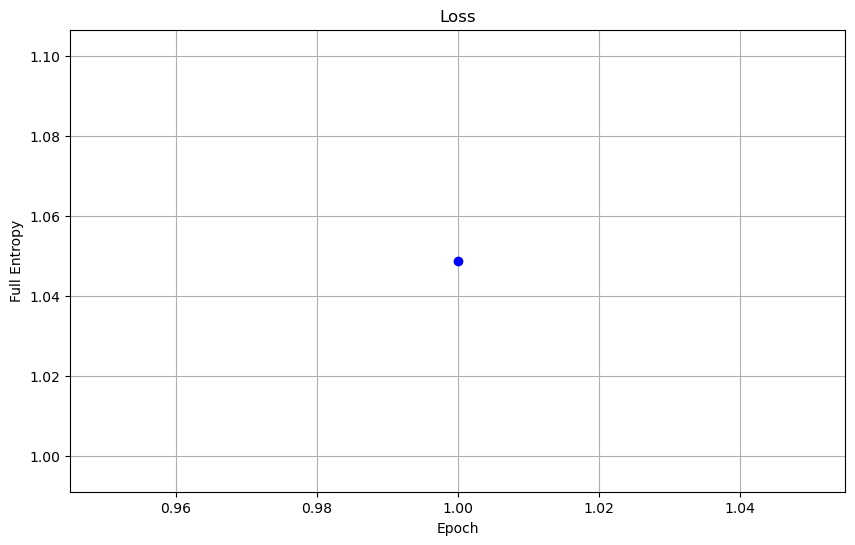

In [328]:
# Plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Full Entropy')
plt.grid(True)
plt.show()

In [329]:
test_loss = full_entropy + 0.01 * sum([model.p.sum() for model in seq_models])
test_loss.backward()

for dim, model in enumerate(seq_models, start=1):
    print(f"Test Gradient magnitude for kernel (dim {dim}): {model.p.grad.abs().mean().item()}")


Test Gradient magnitude for kernel (dim 1): 0.009999998845160007
Test Gradient magnitude for kernel (dim 2): 0.009999998845160007
Test Gradient magnitude for kernel (dim 3): 0.009999999776482582
Test Gradient magnitude for kernel (dim 4): 0.009999999776482582
Test Gradient magnitude for kernel (dim 5): 0.009999999776482582


In [330]:
for i, model in enumerate(seq_models):
    print(f"Kernel {i + 1} requires_grad: {model.p.requires_grad}")


Kernel 1 requires_grad: True
Kernel 2 requires_grad: True
Kernel 3 requires_grad: True
Kernel 4 requires_grad: True
Kernel 5 requires_grad: True


In [331]:
test_loss = seq_models[4].p.sum()  # Compute the sum of the parameter p for the model with dimension 5
test_loss.backward()  # Backpropagation to calculate gradients

# Print the gradient of the parameter p for the model with dimension 5
print(f"Test gradient for kernel 5: {seq_models[4].p.grad}")


Test gradient for kernel 5: tensor([[1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100]])


In [332]:
# Optimization
optimizer.step()  # Update parameters

# Check the updated kernel values for the model with dimension 5
print(f"Updated values for the kernel with dimension 5 (p):\n{seq_models[4].p.data}")

Updated values for the kernel with dimension 5 (p):
tensor([[ 0.3495,  0.6024,  0.3567,  0.6088,  0.7922],
        [ 0.5664,  0.3934,  0.0984,  0.0614,  0.4181],
        [ 0.0474,  0.3251,  0.1313,  0.7335,  0.3622],
        [ 0.4177,  0.2267,  0.1830,  0.4652,  0.7925],
        [ 0.2176,  0.7025,  0.6905, -0.0690,  0.3307],
        [ 0.8569,  0.2109,  0.8263,  0.4886,  0.6147],
        [ 0.3748,  0.3324,  0.9082, -0.0255, -0.0469],
        [ 0.3728, -0.0412,  0.3229,  0.5874,  0.8155],
        [ 0.1466,  0.5193,  0.6693,  0.3055,  0.5049],
        [ 0.1520,  0.5947,  0.6907,  0.4723,  0.5430]])


In [333]:
# Apply forward pass for all models
binary_kernels = [seq_model() for seq_model in seq_models]

# Print the binary kernel result corresponding to dimension 5
print("Generated binary kernel for Dim 5:")
print(binary_kernels[4])  # The kernel for dimension 5

Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.4482],
        [ 0.3387],
        [-0.0010],
        [ 0.1505],
        [-0.3569],
        [ 0.0705],
        [-0.2231],
        [ 0.2990],
        [ 0.2601],
        [ 0.6158]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x1755b9e50>
Output S (grad_fn=<SelectBackward0 object at 0x1755b9e50>):
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.3932,  0.4345],
        [ 0.4805,  0.4316],
        [ 0.3137,  0.4136],
        [ 0.3773,  0.0141],
        [ 0.7026,  0.3844],
        [ 0.0554,  0.2783],
        [ 0.2746,  0.4723],
        [ 0.6488, -0.1031],
        [ 0.3484,  0.7957],
        [-0.1551,  0.6804]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x1755b9e50>
Output

In [334]:
for dim, probs in enumerate(ziv_probs):
    print(f"Probabilities (dim {dim + 1}): {probs}")

Probabilities (dim 1): tensor([0.0647, 0.1151, 0.0647, 0.1151, 0.1151, 0.0647, 0.1151, 0.1151, 0.1151,
        0.1151], grad_fn=<DivBackward0>)
Probabilities (dim 2): tensor([0.0783, 0.0783, 0.1145, 0.1145, 0.0783, 0.0783, 0.1145, 0.1145, 0.1145,
        0.1145], grad_fn=<DivBackward0>)
Probabilities (dim 3): tensor([0.0784, 0.0980, 0.0000, 0.0980, 0.1569, 0.0980, 0.1569, 0.1569, 0.1569,
        0.0000], grad_fn=<DivBackward0>)
Probabilities (dim 4): tensor([0.1707, 0.0976, 0.0976, 0.1220, 0.0976, 0.0488, 0.0488, 0.1707, 0.0488,
        0.0976], grad_fn=<DivBackward0>)
Probabilities (dim 5): tensor([0.2222, 0.1111, 0.2222, 0.0000, 0.1111, 0.2778, 0.0000, 0.0556, 0.0000,
        0.0000], grad_fn=<DivBackward0>)


In [335]:
for i, probs in enumerate(ziv_probs):
    print(f"Probabilities (Dim {i + 1}): {probs.sum().item()}")


Probabilities (Dim 1): 0.9999998807907104
Probabilities (Dim 2): 1.0000001192092896
Probabilities (Dim 3): 1.0
Probabilities (Dim 4): 1.0000001192092896
Probabilities (Dim 5): 1.0000001192092896


In [336]:
# Save a copy of the initial kernel for dimension 1
initial_dim1_kernel = seq_models[0].p.clone().detach()

# Perform the forward pass to generate the binary kernel
binary_kernels = [seq_model() for seq_model in seq_models]

# Get the updated binary kernel for dimension 1
updated_dim1_binary_kernel = binary_kernels[0].detach()

# Compare the initial kernel with the updated (binary) kernel after the forward pass
print("\nInitial kernel for dimension 1:")
print(initial_dim1_kernel)

print("\nUpdated (binary) kernel for dimension 1 after the forward pass:")
print(updated_dim1_binary_kernel)

# Difference between the initial kernel and the updated (binary) kernel
difference = updated_dim1_binary_kernel - initial_dim1_kernel
print("\nDifference between initial and updated (binary) kernel (dim 1):")
print(difference)



Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.4482],
        [ 0.3387],
        [-0.0010],
        [ 0.1505],
        [-0.3569],
        [ 0.0705],
        [-0.2231],
        [ 0.2990],
        [ 0.2601],
        [ 0.6158]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x17563a100>
Output S (grad_fn=<SelectBackward0 object at 0x17563a100>):
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.3932,  0.4345],
        [ 0.4805,  0.4316],
        [ 0.3137,  0.4136],
        [ 0.3773,  0.0141],
        [ 0.7026,  0.3844],
        [ 0.0554,  0.2783],
        [ 0.2746,  0.4723],
        [ 0.6488, -0.1031],
        [ 0.3484,  0.7957],
        [-0.1551,  0.6804]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x17563a100>
Output

In [337]:
# Save a copy of the initial kernels
initial_kernels = [seq_model.p.clone().detach() for seq_model in seq_models]

# Perform the forward pass to generate the updated binary kernels
binary_kernels = [seq_model() for seq_model in seq_models]

# Comparison between initial and updated kernels
print("\n--- Comparison between initial and updated kernels ---")
for dim_index, (initial_kernel, binary_kernel) in enumerate(zip(initial_kernels, binary_kernels)):
    print(f"Dimension {dim_index + 1}:")
    print(f"Initial Kernel:\n{initial_kernel}")
    print(f"Updated (binary) Kernel:\n{binary_kernel}")
    difference = binary_kernel - initial_kernel
    print(f"Difference:\n{difference}")



Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.4482],
        [ 0.3387],
        [-0.0010],
        [ 0.1505],
        [-0.3569],
        [ 0.0705],
        [-0.2231],
        [ 0.2990],
        [ 0.2601],
        [ 0.6158]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x17550fcd0>
Output S (grad_fn=<SelectBackward0 object at 0x175500e50>):
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[ 0.3932,  0.4345],
        [ 0.4805,  0.4316],
        [ 0.3137,  0.4136],
        [ 0.3773,  0.0141],
        [ 0.7026,  0.3844],
        [ 0.0554,  0.2783],
        [ 0.2746,  0.4723],
        [ 0.6488, -0.1031],
        [ 0.3484,  0.7957],
        [-0.1551,  0.6804]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x175500e50>
Output